## Bayesian Optimizaiton with cross entropy method (CEM) and prediction with Gaussian processes

This is a program to perform Bayesian optimization with Gaussian processes and determine the sample that maximizes the UCB function with the cross entropy method.

First, we deinfe the ground truth function, which is dealt with as an unknown funciton.

In [ ]:
import numpy as np
import scipy as sci
from scipy.stats import norm

def f(x):
    """The function to predict."""
    return x*np.sin(x)

We define the kernel function and a Gaussian process.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Prepare the kernel function
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
kernel = 1.0 * RBF(1, (1e-2, 1e2))
dy = 0.05

# Prepare the Gaussian process instance
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)


We define a function to perform prediction using the Gaussian process.
We also define the acquisition functions.

In [ ]:
def gp_pred(x, gp=gp):
    mean, std = gp.predict(x, return_std=True)
    return mean, std

# Upper confidence bound
def UCB(x, y_data, f=gp_pred):
    mean, std = f(x)
    return mean + 2.0*std

# Expected improvement
def EI(x, y_data, f=gp_pred):
    mean, std = f(x)
    y_max = np.max(y_data)
    ei = (mean - y_max) * norm.cdf((mean - y_max)/std, loc=0, scale=1) + std * norm.pdf((mean - y_max)/std, loc=0, scale=1)

    return ei

We define a function for the cross entropy method.

In [ ]:
import numpy as np

def Cem(objfunc, y_data, x_min=0, x_max=2, dim=1, iterMax=5, sampleNum=200, eliteNum=20):

    mean = None
    std = None
    sampleSet = None
    valueSet = None

    for i in range(iterMax):

        if i == 0:
            sampleSet_i = np.random.uniform(x_min, x_max, (sampleNum, dim))
            sampleSet_i = np.clip(sampleSet_i, x_min, x_max)
        else:
            sampleSet_i = np.random.normal(loc=mean, scale=std, size=sampleNum)
            sampleSet_i = np.clip(sampleSet_i, x_min, x_max)

        sampleSet = np.reshape(sampleSet_i, (sampleNum, -1))
        valueSet = objfunc(sampleSet, y_data)

        value_sort = np.sort(valueSet, axis=None)
        # print('value_sort', value_sort)
        data_num = sampleSet.shape[0]
        v_cut = value_sort[data_num - eliteNum -1]

        # print('sampleSet', sampleSet.shape)
        # print('valueSet', valueSet.shape)
        # print('v_cut', v_cut)
        idx = (valueSet.flatten() > v_cut)
        valueSetCut = valueSet[idx]
        sampleSetCut = sampleSet[idx, :]

        # print('sampleSetCut.shape', sampleSetCut.shape)
        mean = np.mean(sampleSetCut)
        std = np.std(sampleSetCut)

        sampleSetList = list(sampleSetCut)
        valueSetList = list(valueSetCut)

        np.clip(mean, x_min, x_max)


    return np.clip(mean, x_min, x_max)

Observation data is prepared by injecting noises to the true values.

In [ ]:
# X = np.linspace(0.1, 9.9, 20)
# X = np.random.uniform(0, 10, 7)
X = np.array([0.2, 1.5, 2.1, 3.5, 8.1, 9.5])
X = np.atleast_2d(X).T

y = f(X).ravel()
noise = np.random.normal(0, dy)
y += noise

The Gaussian process is fitted with the given data.

In [ ]:
gp.fit(X, y)

GaussianProcessRegressor(alpha=0.0025000000000000005,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

The point that maximizes the UCB/EI is determined using CEM based on the prediction with the Gaussian process.

In [ ]:
mean = Cem(UCB, y_data=y, dim=1, x_min=0, x_max=10)
#mean = Cem(EI, y_data=y, dim=1, x_min=0, x_max=10)
print('mean', mean)

mean 7.256626760227094


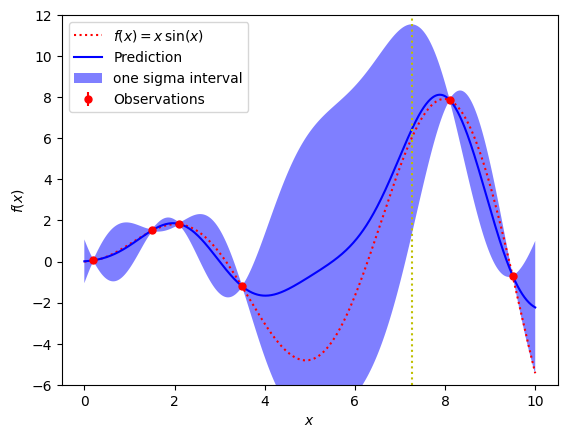

In [ ]:
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

from matplotlib import pyplot as plt

y_max = 12
y_min = -6

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.0 * sigma,
                        (y_pred + 2.0 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='one sigma interval')

# plt.fill(np.concatenate([x, x[::-1]]),
        #  np.concatenate([y_pred - 1.9600 * sigma,
                        # (y_pred + 1.9600 * sigma)[::-1]]),
        #  alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.vlines(mean, y_min, y_max, color='y', linestyles='dotted')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(y_min, y_max)
# plt.ylim(-2.5, 2.5)
plt.legend(loc='upper left')


Assuming that the new observation is obtained based on this sample, we add a new datapoint.

---



In [ ]:
X_append = np.append(X, mean)
X_append = np.atleast_2d(X_append).T

The Gaussian process is updaed using the updated data, and we determine a point that maximizes the acquisition function.

mean 7.810569478557177


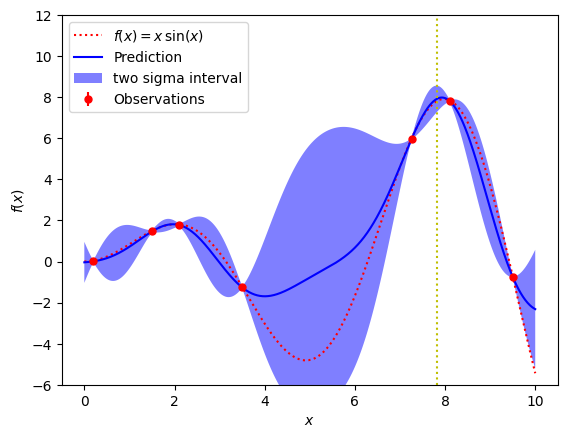

In [ ]:
y_append = f(X_append).ravel()
noise_append = np.random.normal(0, dy)
y_append += noise_append

gp.fit(X_append, y_append)

mean = Cem(UCB, y_append, dim=1, x_min=0, x_max=10)
#mean = Cem(EI, y_append, dim=1, x_min=0, x_max=10)
print('mean', mean)

y_pred, sigma = gp.predict(x, return_std=True)

from matplotlib import pyplot as plt

y_max = 12
y_min = -6

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X_append.ravel(), y_append, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.0 * sigma,
                        (y_pred + 2.0 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='two sigma interval')

# plt.fill(np.concatenate([x, x[::-1]]),
        #  np.concatenate([y_pred - 1.9600 * sigma,
                        # (y_pred + 1.9600 * sigma)[::-1]]),
        #  alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.vlines(mean, y_min, y_max, color='y', linestyles='dotted')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(y_min, y_max)
# plt.ylim(-2.5, 2.5)
plt.legend(loc='upper left')

mean 7.971246831228787


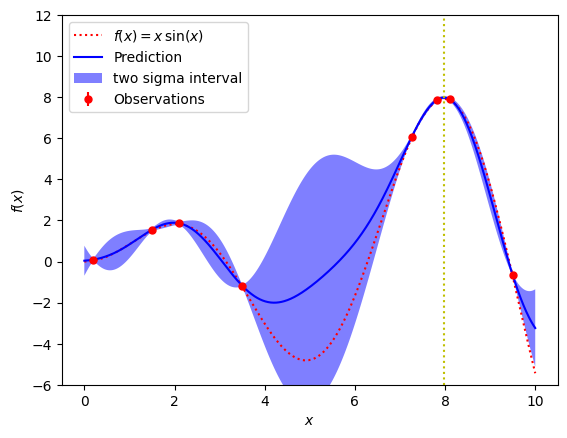

In [ ]:
X_append2 = np.append(X_append, mean)
X_append2 = np.atleast_2d(X_append2).T

y_append2 = f(X_append2).ravel()
noise_append = np.random.normal(0, dy)
y_append2 += noise_append

gp.fit(X_append2, y_append2)

mean = Cem(UCB, y_append2, dim=1, x_min=0, x_max=10)
# mean = Cem(EI, y_append2, dim=1, x_min=0, x_max=10)
print('mean', mean)

y_pred, sigma = gp.predict(x, return_std=True)

from matplotlib import pyplot as plt

y_max = 12
y_min = -6

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X_append2.ravel(), y_append2, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.0 * sigma,
                        (y_pred + 2.0 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='two sigma interval')

# plt.fill(np.concatenate([x, x[::-1]]),
        #  np.concatenate([y_pred - 1.9600 * sigma,
                        # (y_pred + 1.9600 * sigma)[::-1]]),
        #  alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.vlines(mean, y_min, y_max, color='y', linestyles='dotted')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(y_min, y_max)
# plt.ylim(-2.5, 2.5)
plt.legend(loc='upper left')